In [1]:
import sys
import os
sys.path.append("/home/pi/EE123/Chirp-EE123")

cur_path = os.path.dirname('/home/pi/EE123/Chirp-EE123')
sys.path.insert(0, '/home/pi/EE123/Chirp-EE123/src')

from utils.EE123TNC import *
from utils.hamming import *

import sounddevice as sd
import RPi.GPIO as GPIO

# Load image/gif into queue

In [21]:
fname = b"calBlue.tiff"
f1=open('rec_calBlue2.tiff','wb')
f = open(fname,"rb")
fs = 48000
modem = TNCaprs(fs = fs ,Abuffer = 512,Nchunks = 10)
print("Putting packets in Queue")

starttime = time.time()
npack = 0
prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(40,)).tolist())
Qout=Queue.Queue()
while True:
    chunk=f.read(256)
    if chunk:
        info = chunk
        info += bytes(256 - len(info))
        f1.write(info)
#         print(len(info))
        packet = ax25.UI(info=info)
        bits=modem.NRZ2NRZI(prefix+packet.unparse()+prefix)
        packets = modem.modulate(bits)
        Qout.put(packets)
    else:
        break

print("Processing took:", time.time()-starttime)
print("Done")

f.close()

Putting packets in Queue
Processing took: 2.5710527896881104
Done


-rw-r--r-- 1 pi pi 8746 May  5 17:54 calBlue.tiff
-rw-r--r-- 1 pi pi 8746 May  5 18:07 rec_calBlue.tiff


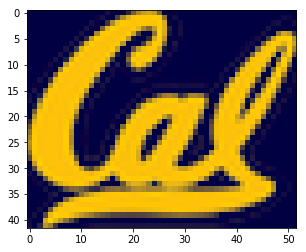

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
path = "rec_calBlue2.tiff"
a = Image.open(path)
plt.imshow(a)

!ls -ltr *calBlue.tiff

# Transmit image/gif

In [22]:
GPIO.cleanup()
GPIO.setmode(GPIO.BOARD)
PTT = 16
GPIO.setup(PTT, GPIO.OUT, initial = 0)

print("Starting transmission...")
starttime = time.time()

GPIO.output(PTT, GPIO.HIGH)
while(not(Qout.empty())):
    sig=Qout.get()
    sd.play(sig*0.2,samplerate=48000,device=usb_idx, blocking=True)
GPIO.output(PTT, GPIO.LOW)

print("Done")
print(time.time() - starttime)

Starting transmission...
Done
109.69600296020508
